# This notebook is written by: 

Will Chapman (wchapman@ucsd.edu), Aneesh Subramanian (aneeshcs@colorado.edu) & Judith Berner (berner@ucar.edu) for the NCAR ASP2021 S2S summer school

Thank XXXXXXXXX for the computational resources to complete this work, and the CESM LENS project for providing the data, and running the models

Please see the ["To-Do"](https://docs.google.com/document/d/1gnOO68qfoamWgwv815QZTotxHdsEFl5zV_q-Brd0z1I/edit?usp=sharing) document to keep track of progress. 


In [ ]:
# Packages have to go in this order... I don't know why

import numpy as np
import pandas as pd
import xarray as xr
import eofs
from eofs.standard import Eof
import glob



# #this annoying. you need intake-esm V 2020.11.4 and intake V 0.6.0

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm

import copy
import fsspec
import pop_tools
import intake
import scipy.stats
from IPython.display import Image 

from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn import preprocessing

import tensorflow as tf
import util

In [70]:
import importlib
importlib.reload(util)

<module 'util' from '/glade/work/wchapman/git_ASP_SS/ml_tutorial_asp2021/notebooks/util.py'>

## Now we are going to Neural Networks for Every Lat/Lon Location and Train on Years 500-599 and Test on Years 600 - 699


Please go through Johnson_et_al_rolling.ipynb before running this notebook! The task is the same, but the empirical model is different! If you are familiar with that notebook, then this one will be very similar. 


We will be using the Tensorflow + Keras tool box to forecast each point. 


----To skip the model training and just leverage pretrained models .. you can scrolllll down----


Here is a tutorial on supervised machine learning methods from the AMS (written by Will Chapman). This notebook is also included in our github

[AMS Tutorial on Supervised Learning](https://sites.google.com/view/amsai2021shortcourse/introduction-to-ml?authuser=0)


Here is a tutorial on decision tree based methods from the AMS. It would be VERY smart to go through it. 

[AMS Tutorial on Network Based ML Models](https://sites.google.com/view/amsai2021shortcourse/introduction-to-ml?authuser=0)


Here is a primer on Deep Learning. This is seriously the best explaination of the fundamentals I've ever seen.... please watch it! 

[Deep Learning Video Series](https://www.youtube.com/watch?v=aircAruvnKk&ab_channel=3Blue1Brown)



## First Let's select a R.O.I.

In [2]:
print('###### set spatial bounds ######')
# lat_bounds = [15,90]
# lon_bounds = [170,315]  #N/A 

lat_bounds = [-90,90]
lon_bounds = [0,360]  #Global

print('bounding lat:',lat_bounds,'; bounding lon:',lon_bounds)
print('###### set spatial bounds ######')

###### set spatial bounds ######
bounding lat: [-90, 90] ; bounding lon: [0, 360]
###### set spatial bounds ######


## Get Land Mask 
This is usefeul for later when we plot skill/ composites 

For this baseline we will just slice for North America, but all the data is available.

In [3]:
%%time
filly = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc'
grid = xr.open_dataset(filly)
LM = grid.sel(lat=slice(lat_bounds[0],lat_bounds[1]),lon=slice(lon_bounds[0],lon_bounds[1]))
LM = np.array(LM['LANDFRAC'][0,:,:])
LM[LM==0]=np.nan
# landmask = grid.landmask.load()
# landmask = np.array(landmask.sel(lat=slice(15,90),lon=slice(170,315)))

CPU times: user 29.7 ms, sys: 8.61 ms, total: 38.4 ms
Wall time: 37.5 ms


## Compare the Johnson et al (2014) method for 3-4 week forecasts with a Neural Network Approach ... using the same data

Skillful Wintertime North American Temperature Forecasts out to 4 Weeks Based on the State of ENSO and the MJO

https://journals.ametsoc.org/view/journals/wefo/29/1/waf-d-13-00102_1.xml

## Load MJO and ENSO

In [4]:
DSn34=xr.open_dataset('/glade/work/wchapman/ASP_summerschool/datasets/NINO34_monthly_500_999.nc')
mjofils = sorted(glob.glob('/glade/work/wchapman/ASP_summerschool/datasets/MJO/*.nc'))
DSmjo=xr.open_mfdataset(mjofils,combine='by_coords')

In [5]:
DSmjo

<xarray.Dataset>
Dimensions:    (time: 182500)
Coordinates:
  * time       (time) object 0500-01-01 00:00:00 ... 0999-12-31 00:00:00
Data variables:
    MJO_INDEX  (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>
    PC1        (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>
    PC2        (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>

## Open Anomaly Dataset <a class="anchor" id="fifth-bullet"></a>

We have pre-prepared this dataset->

Daily T2m PSL and PRECL files have been downloaded from the cloud, we fit and remove the first 8 harmonics (sine/cosine waves) to calculate the anomalies, we then used a 7-day rolling average filter to get rolling weekly anomalies. The terciles have been precomputed. see **glade/work/wchapman/git_ASP_SS/ml_tutorial_asp2021/notebooks/Build_Weekly_Anomaly_Files.ipynb** for this calculation

In [6]:
Anoms_weekly =xr.open_dataset('/glade/scratch/wchapman/ASP_summerschool/datsets/Daily_Rolling7day_Global_with_GroundTruth_RUN2_LENS_CTRL_PSL_TS_PRECL_500_599.nc')
Anoms_weekly = Anoms_weekly.sel(lat=slice(lat_bounds[0],lat_bounds[1]),lon=slice(lon_bounds[0],lon_bounds[1]))


In [7]:
#MJO pandas data frame
DFmjo =pd.DataFrame({'Month':DSmjo['time.month'].data,'Year':DSmjo['time.year'].data,'Day':DSmjo['time.day'].data,'MJO_INDEX':np.array(DSmjo['MJO_INDEX']),'MJO_PC1':np.array(DSmjo['PC1']),'MJO_PC2':np.array(DSmjo['PC2'])})
DFmjo.head(10)

,Month,Year,Day,MJO_INDEX,MJO_PC1,MJO_PC2
0,1,500,1,NaN,NaN,NaN
1,1,500,2,NaN,NaN,NaN
2,1,500,3,NaN,NaN,NaN
3,1,500,4,NaN,NaN,NaN
4,1,500,5,NaN,NaN,NaN
5,1,500,6,NaN,NaN,NaN
6,1,500,7,NaN,NaN,NaN
7,1,500,8,NaN,NaN,NaN
8,1,500,9,NaN,NaN,NaN
9,1,500,10,NaN,NaN,NaN


## Load MJO and ENSO <a class="anchor" id="fourth-bullet"></a>

MJO and ENSO indices have been precalculated and are stored in the below working directories. Aneesh Subramanian calculated the MJO based using the RMM1&2 method. ENSO index is the NINO3.4 region anomaly using every 100 years as a rolling base year. This data has been first downloaded from the CESM LENS cloud storage, and has been processed for ease of access / use. You can see the calculations in the directory (glade/work/wchapman/git_ASP_SS/ml_tutorial_asp2021/notebooks)


## Here is an MJO Phase Primer:

To Get the Phase of the MJO_Index:

"eight phases that are divided evenly and each occupies 45° on the RMM phase diagram. The angle is defined by the arctangent of RMM2 over RMM1 in degrees and a negative value is converted to positive by adding 360°. As an example, phase 1 is located in the half-open range of (180°, 225°]. The RMM1 is generally nonzero so all angles are defined."


As a reminder this image shows the phases vs locations in PC space 

In [ ]:
DSn34=xr.open_dataset('/glade/work/wchapman/ASP_summerschool/datasets/NINO34_monthly_500_999.nc')
mjofils = sorted(glob.glob('/glade/work/wchapman/ASP_summerschool/datasets/MJO/*.nc'))
DSmjo=xr.open_mfdataset(mjofils,combine='by_coords')
#MJO pandas data frame
DFmjo =pd.DataFrame({'Month':DSmjo['time.month'].data,'Year':DSmjo['time.year'].data,'Day':DSmjo['time.day'].data,'MJO_INDEX':np.array(DSmjo['MJO_INDEX']),'MJO_PC1':np.array(DSmjo['PC1']),'MJO_PC2':np.array(DSmjo['PC2'])})
DFmjo.head(10)

In [ ]:
Image(url='https://rmets.onlinelibrary.wiley.com/cms/asset/104802a6-dc1f-4176-9705-03cfbb34ad3e/met1780-fig-0004-m.jpg', width=600)


In [9]:
%%time
#we do the MJO phase calculation here:
MJO_phase = []

for ii in range(DFmjo.shape[0]):
    MJO_INDEX = DFmjo.iloc[ii]['MJO_INDEX']
    RMM1 = DFmjo.iloc[ii]['MJO_PC1']
    RMM2 = DFmjo.iloc[ii]['MJO_PC2']
    
    
    if np.isnan(MJO_INDEX):
        MJO_phase.append(np.nan)
    elif MJO_INDEX < 1:
        MJO_phase.append(0)
    else:
        ang = np.degrees(np.arctan2(RMM2,RMM1))
        if ang<0:
            ang = ang+360
        ang = ang+180 

        if ang > 360:
            ang=ang-360
            
        MJO_phase.append(np.floor((ang)/45)+1)
        
        
DFmjo['MJO_Phase']=MJO_phase
DFmjo.head(10)
print('...ignore the initial nan values... the dates are there....')

...ignore the initial nan values... the dates are there....
CPU times: user 1min 4s, sys: 36 ms, total: 1min 4s
Wall time: 1min 4s


## Create a Pandas DataFrame to Drive the Forecasts <a class="anchor" id="sixth-bullet"></a>

A Pandas dataframe is a convenient and accessible data storage system. Pandas DataFrame is two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns). A Data frame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns.

This data frame will be used:

1. to make sure that our verification initialization dates are aligned. 
2. track the large scale indices used to create our forecasts. 

In [10]:
%%time
#pandas data frame
DFalltimes = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})

DFforecast = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})
print('intermediate dataframe:')
print(DFforecast.head(10))

#ENSO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)

#MJO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)



print('...building ENSO in DFforecast...')

ENSOind = []
MJOind = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    ENSOind.append(np.array(DFenso[(DFenso['Month']==mo)&(DFenso['Year']==yr)]['ENSO'])[0])
    
print('...building MJO in DFforecast...')
MJOind = []
PC1ind = []
PC2ind = []
MJOphase = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    dy = DFforecast.Day[bb]
    
    indy = DFmjo[(DFmjo['Month']==mo)&(DFmjo['Year']==yr)&(DFmjo['Day']==dy)].index
    
    MJOind.append(np.array(DFmjo.loc[indy,:]['MJO_INDEX'])[0])
    PC1ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC1'])[0])
    PC2ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC2'])[0])
    MJOphase.append(np.array(DFmjo.loc[indy,:]['MJO_Phase'])[0])
    
    
DFforecast['ENSO']=ENSOind
DFforecast['MJO_INDEX']=MJOind
DFforecast['MJO_PC1']=PC1ind
DFforecast['MJO_PC2']=PC2ind
DFforecast['MJO_Phase']=MJOphase


DFforecast.head(10)


print('our Forecast Dataframe has:',DFforecast.shape[0],'daily forecast initialzations; spanning years:',DFforecast['Year'][0] ,'to',np.unique(DFforecast['Year'])[-1])

intermediate dataframe:
   Year  Month  Day
0   600      1    1
1   600      1    2
2   600      1    3
3   600      1    4
4   600      1    5
5   600      1    6
6   600      1    7
7   600      1    8
8   600      1    9
9   600      1   10
...building ENSO in DFforecast...
...building MJO in DFforecast...
our Forecast Dataframe has: 36500 daily forecast initialzations; spanning years: 600 to 699
CPU times: user 2min 35s, sys: 102 ms, total: 2min 35s
Wall time: 2min 35s


## Get The Lagged Predictor Field

 <font color='green'><font size="35">Set the variable "Lead" to determine the specified forecast "lead time"</font></font> 


In [11]:
%%time
Lead=21  #This is in units "days"
forecastMonth=[]
forecastYear=[]
forecastDay=[]
ind_forecast=[]
print('...diving in....')
countuppp =0 
for ii in range(DFforecast.shape[0]):
    mo = DFforecast['Month'][ii]
    yr = DFforecast['Year'][ii]
    da = DFforecast['Day'][ii]
    leadind =  DFforecast[(DFalltimes['Month']==mo)&(DFalltimes['Year']==yr)&(DFalltimes['Day']==da)].index[0]+Lead
    
    if leadind < DFalltimes.shape[0]:
        forecastMonth.append(DFalltimes['Month'][leadind])
        forecastDay.append(DFalltimes['Day'][leadind])
        forecastYear.append(DFalltimes['Year'][leadind])
    else:
        countuppp+=1
        if countuppp==1:
            print('....done...?')
        forecastMonth.append(-999)
        forecastDay.append(-999)
        forecastYear.append(-999)
        
    
    if leadind >= DFalltimes.shape[0]:
        ind_forecast.append(-999)
    elif (DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==0):
        ind_forecast.append(-999)
    elif DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==1:
        ind_forecast.append(DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].index[0])
    else:
        print('...ohhh nooo something is seriously broken...')
        
#append this to the data forecast. 
DFforecast['Month_3lead'] = forecastMonth
DFforecast['Year_3lead'] = forecastYear
DFforecast['Day_3lead'] = forecastDay
DFforecast['Ind_3lead'] = ind_forecast

#drop any forecasts verifying in april. Remove from ALLL datasets. ~ 5400 forecasts. 
verifApril = DFforecast[DFforecast['Month_3lead']==4].index
DFforecast.iloc[verifApril]
print('sum of countup (this should = leadtime):',countuppp)

...diving in....
....done...?
sum of countupp (this should = leadtime): 21
CPU times: user 3min 36s, sys: 66.9 ms, total: 3min 36s
Wall time: 3min 36s



<font color='black'><font size="35">Drop Rows with NaN values</font></font> 

Then show how many independent predictors we have remaining 

In [12]:
DFforecast= DFforecast.dropna()
print('The predictor space has ',DFforecast.shape[0],' samples with',np.unique(DFforecast['Year']).shape[0],'years to cross-validate on' )

The predictor space has  36299  samples with 100 years to cross-validate on


<font color='black'><font size="35">Lets subset for winter months</font></font> 

forecasts initialized in Dec - > Feb. 

In [13]:
DFforecast_DJFM = DFforecast[(DFforecast['Month']==12)|(DFforecast['Month']==1)|(DFforecast['Month']==2)] 
forecastindices = DFforecast_DJFM.index
verificationindices =DFforecast_DJFM['Ind_3lead']

print('The predictor space has ',DFforecast_DJFM.shape[0],' samples with',np.unique(DFforecast_DJFM['Year']).shape[0],'years to cross-validate on' )
DFforecast_DJFM.head(45)

The predictor space has  8910  samples with 100 years to cross-validate on


,Year,Month,Day,ENSO,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase,Month_3lead,Year_3lead,Day_3lead,Ind_3lead
334,600,12,1,1.251835,0.973953,0.985964,0.042760,0.0,12,600,22,355
335,600,12,2,1.251835,1.044439,1.021977,-0.001285,4.0,12,600,23,356
336,600,12,3,1.251835,1.086870,1.040162,-0.070235,4.0,12,600,24,357
337,600,12,4,1.251835,1.096489,1.034405,-0.162771,4.0,12,600,25,358
338,600,12,5,1.251835,1.075187,0.999735,-0.275167,4.0,12,600,26,359
339,600,12,6,1.251835,1.031325,0.932819,-0.401464,4.0,12,600,27,360
340,600,12,7,1.251835,0.977810,0.832357,-0.533847,0.0,12,600,28,361
341,600,12,8,1.251835,0.928834,0.699317,-0.663166,0.0,12,600,29,362
342,600,12,9,1.251835,0.896130,0.537011,-0.779583,0.0,12,600,30,363
343,600,12,10,1.251835,0.885832,0.350977,-0.873297,0.0,12,600,31,364


## Plot Specified Index anomaly. <a class="anchor" id="anomaly-bullet"></a>

you can change the variable of the data table below to show the conditioned anomaly 

In [14]:
# change this variable

# example for enso... you need to change the condition below to >=
# phaser = 'ENSO'
# phase=1
# i.e. Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM[phaser]>=phase]['Ind_3lead'])

phaser = 'MJO_Phase'
phase=8

Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM[phaser]==phase]['Ind_3lead'])
TS = np.array(Anoms_weekly['TS_anom']).squeeze()
#get all of our indices"
lat = np.array(Anoms_weekly['lat'])
lon = np.array(Anoms_weekly['lon'])

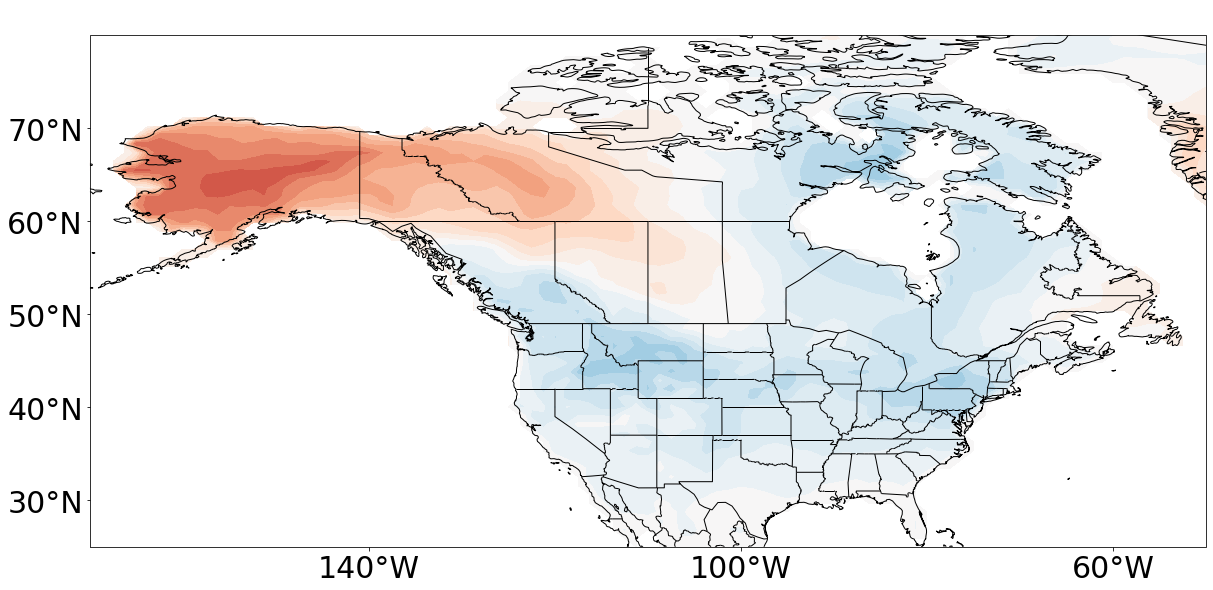

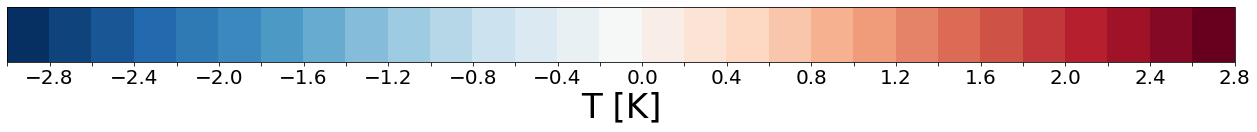

In [15]:
plot_field= np.mean(TS[Ninoind,:,:],axis=0).squeeze()*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-3,3,0.2) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()


<font color='black'><font size="30">This is Your DataSet</font></font> 

In [16]:
Anoms_weekly

<xarray.Dataset>
Dimensions:     (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 36500)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id   (member_id) int64 1
  * time        (time) object 0600-01-01 12:00:00 ... 0699-12-31 12:00:00
    time_bnds   (time, nbnd) object ...
Dimensions without coordinates: nbnd
Data variables:
    PRECL       (member_id, time, lat, lon) float32 ...
    PSL         (member_id, time, lat, lon) float32 ...
    TS          (member_id, time, lat, lon) float32 ...
    PSL_anom    (member_id, time, lat, lon) float32 ...
    TS_anom     (member_id, time, lat, lon) float32 nan nan nan ... nan nan nan
    PRECL_anom  (member_id, time, lat, lon) float32 ...
    TS_terc     (member_id, time, lat, lon) float32 ...
    PSL_terc    (member_id, time, lat, lon) float32 ...
    PRECL_terc  (member_id, time, lat, lon) float32 ...

<font color='black'><font size="7">Load Variables</font></font> 

In [17]:
TS = np.array(Anoms_weekly['TS_anom']).squeeze() #current temp 
TS_ver = np.array(Anoms_weekly['TS_terc']).squeeze() #anomaly tercile.

lat = np.array(Anoms_weekly['lat'])
lon = np.array(Anoms_weekly['lon'])

In [18]:
import os
os.getcwd()

'/glade/work/wchapman/git_ASP_SS/ml_tutorial_asp2021/notebooks'

In [90]:
in_shape=X_train.shape[1]
MOD_SAVE = '/glade/scratch/wchapman/ASP_summerschool/NN_models/NN_lat_'+str(lat[lala])+'_lon_'+str(lon[lolo])+'.ckpt'
model = util.build_nn_model(in_shape,3,[30,40],2,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
modsave = tf.keras.callbacks.ModelCheckpoint(MOD_SAVE, monitor='val_accuracy', verbose=1, save_best_only=True,save_weights_only=True, mode='auto',include_optimizer=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.4,patience=2, min_lr=0.00001,verbose=1)
er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()
model.fit(X_train[:-1000,:],Y_train[:-1000],validation_data=(X_train[-1000:,:],Y_train[-1000:]),epochs=50,callbacks=[modsave,reduce_lr,er_stop])


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 12)]              0         
_________________________________________________________________
dense_99 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_100 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_101 (Dense)            (None, 3)                 123       
Total params: 1,753
Trainable params: 1,753
Non-trainable params: 0
_________________________________________________________________
Train on 7910 samples, validate on 1000 samples
Epoch 1/50
7392/7910 [===========================>..] - ETA: 0s - loss: 1.0780 - accuracy: 0.4127
Epoch 00001: val_accuracy improved from -inf to 0.37400, saving model to /glade/scratch/wchapman/ASP_summers

## Run the Neural Network at Every (land) Point!

In [ ]:
Training_inds = np.array(DFforecast_DJFM.index)
DF_train = DFforecast_DJFM
ylb = preprocessing.LabelBinarizer().fit(DF_train.MJO_Phase)
MJO_Phase_Train=ylb.transform(DF_train.MJO_Phase).T
X_train = np.concatenate([np.array(DF_train['ENSO'])[None,...],np.array(DF_train['MJO_PC1'])[None,...],np.array(DF_train['MJO_PC2'])[None,...],MJO_Phase_Train],axis=0).T
    
    
HSS_map = np.zeros([lat.shape[0],lon.shape[0]])
countup = 0
print('...starting...')
for lala in range(lat.shape[0]):
    for lolo in range(lon.shape[0]):
        countup+=1
        if countup % 100 ==0:
            print('iteration:',countup,'of',lat.shape[0]*lon.shape[0])
            print('lat:',lat[lala],'lon',lon[lolo])
        if np.isnan(LM[lala,lolo]):
            continue
    
        targ_train_ind = np.array(DF_train['Ind_3lead']).astype(int)    
        Y_train= TS_ver[targ_train_ind,lala,lolo].squeeze().astype(int)
   
        
        in_shape=X_train.shape[1]
        MOD_SAVE = '/glade/scratch/wchapman/ASP_summerschool/NN_models/NN_lat_'+str(lat[lala])+'_lon_'+str(lon[lolo])+'_Lead_'+str(Lead)+'.ckpt'
        model = util.build_nn_model(in_shape,3,[30,40],2,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        modsave = tf.keras.callbacks.ModelCheckpoint(MOD_SAVE, monitor='val_accuracy', verbose=0, save_best_only=True,save_weights_only=True, mode='auto',include_optimizer=False)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.4,patience=0, min_lr=0.00001,verbose=0)
        er_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=0, mode='auto',baseline=None, restore_best_weights=False)
        opt = tf.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#         model.summary()
        model.fit(X_train[:-1000,:],Y_train[:-1000],validation_data=(X_train[-1000:,:],Y_train[-1000:]),epochs=50,callbacks=[modsave,reduce_lr,er_stop],verbose=0)

        
        yh =  model.predict(X_train)
        yh=np.argmax(yh,axis=1)
        Forecast=yh
        Verif = Y_train
        hits =0
        for bb in range(Verif.shape[0]):
            hits+=np.sum(Verif[bb] == Forecast[bb])
        
        HSS = (hits-(int(len(Verif)*0.3333)))/(len(Verif)-(int(len(Verif)*0.3333)))*100
        HSS_map[lala,lolo]=HSS
        

...starting...
iteration: 100 of 55296
lat: -90.0 lon 123.75
iteration: 200 of 55296
lat: -90.0 lon 248.75
iteration: 300 of 55296
lat: -89.0575942993164 lon 13.75
iteration: 400 of 55296
lat: -89.0575942993164 lon 138.75
iteration: 500 of 55296
lat: -89.0575942993164 lon 263.75
iteration: 600 of 55296
lat: -88.1151809692383 lon 28.75
iteration: 700 of 55296
lat: -88.1151809692383 lon 153.75
iteration: 800 of 55296
lat: -88.1151809692383 lon 278.75
iteration: 900 of 55296
lat: -87.1727752685547 lon 43.75
iteration: 1000 of 55296
lat: -87.1727752685547 lon 168.75
iteration: 1100 of 55296
lat: -87.1727752685547 lon 293.75
iteration: 1200 of 55296
lat: -86.2303695678711 lon 58.75
iteration: 1300 of 55296
lat: -86.2303695678711 lon 183.75
iteration: 1400 of 55296
lat: -86.2303695678711 lon 308.75
iteration: 1500 of 55296
lat: -85.287956237793 lon 73.75
iteration: 1600 of 55296
lat: -85.287956237793 lon 198.75
iteration: 1700 of 55296
lat: -85.287956237793 lon 323.75
iteration: 1800 of 5529

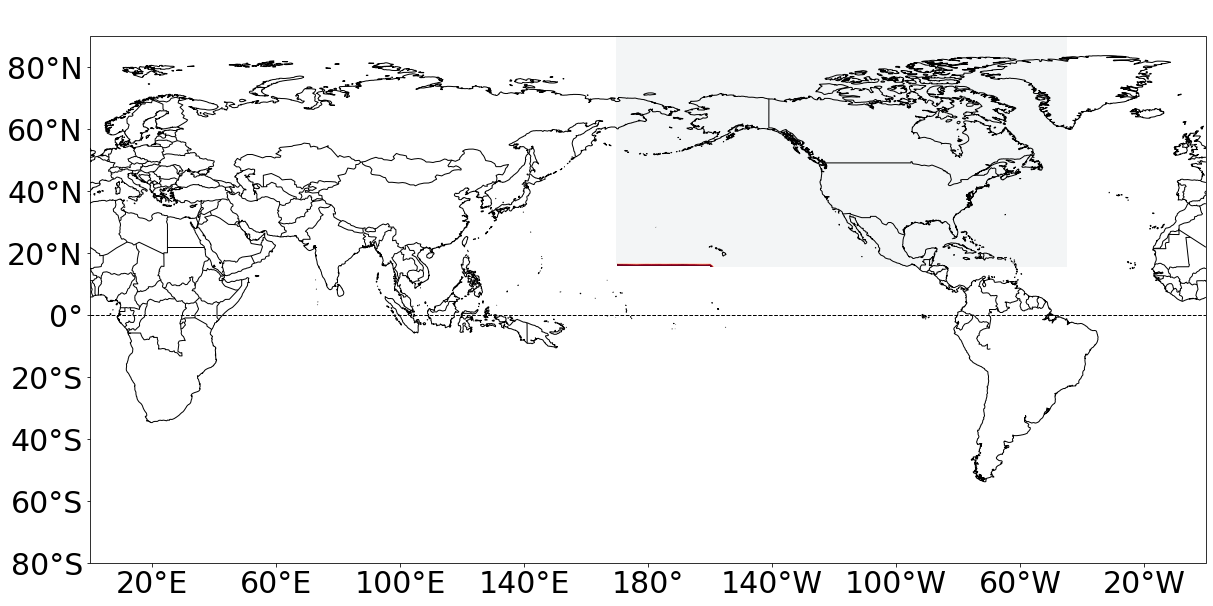

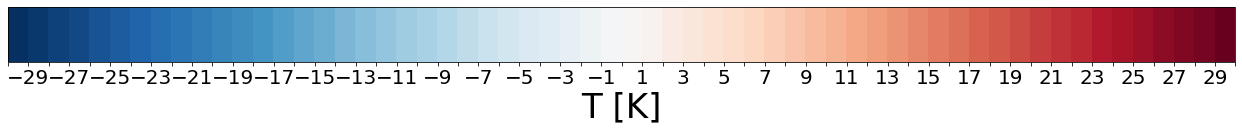

In [37]:
plot_field= HSS_map.squeeze()

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-30,31,1) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([-180,180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-80,100,20), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
# ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()



## Now we Load the testing Data:

Do this all in one cell--->

In [19]:
%%time

#grab indices datasets: 
DSn34=xr.open_dataset('/glade/work/wchapman/ASP_summerschool/datasets/NINO34_monthly_500_999.nc')
mjofils = sorted(glob.glob('/glade/work/wchapman/ASP_summerschool/datasets/MJO/*.nc'))
DSmjo=xr.open_mfdataset(mjofils,combine='by_coords')

#grab anomaly datasets:
Anoms_weekly =xr.open_dataset('/glade/scratch/wchapman/ASP_summerschool/datsets/Daily_Rolling7day_Global_with_GroundTruth_RUN2_LENS_CTRL_PSL_TS_PRECL_600_699.nc')
Anoms_weekly = Anoms_weekly.sel(lat=slice(lat_bounds[0],lat_bounds[1]),lon=slice(lon_bounds[0],lon_bounds[1]))

#MJO pandas data frame
DFmjo =pd.DataFrame({'Month':DSmjo['time.month'].data,'Year':DSmjo['time.year'].data,'Day':DSmjo['time.day'].data,'MJO_INDEX':np.array(DSmjo['MJO_INDEX']),'MJO_PC1':np.array(DSmjo['PC1']),'MJO_PC2':np.array(DSmjo['PC2'])})
DFmjo.head(10)

MJO_phase = []

for ii in range(DFmjo.shape[0]):
    MJO_INDEX = DFmjo.iloc[ii]['MJO_INDEX']
    RMM1 = DFmjo.iloc[ii]['MJO_PC1']
    RMM2 = DFmjo.iloc[ii]['MJO_PC2']
    
    
    if np.isnan(MJO_INDEX):
        MJO_phase.append(np.nan)
    elif MJO_INDEX < 1:
        MJO_phase.append(0)
    else:
        ang = np.degrees(np.arctan2(RMM2,RMM1))
        if ang<0:
            ang = ang+360
        ang = ang+180 

        if ang > 360:
            ang=ang-360
            
        MJO_phase.append(np.floor((ang)/45)+1)
        
        
DFmjo['MJO_Phase']=MJO_phase
DFmjo.head(10)
print('...ignore the initial nan values... the dates are there....')


###################################
#pandas data frame
DFalltimes = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})

DFforecast = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})
print('intermediate dataframe:')
print(DFforecast.head(10))

#ENSO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)

#MJO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)



print('...building ENSO in DFforecast...')

ENSOind = []
MJOind = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    ENSOind.append(np.array(DFenso[(DFenso['Month']==mo)&(DFenso['Year']==yr)]['ENSO'])[0])
    
print('...building MJO in DFforecast...')
MJOind = []
PC1ind = []
PC2ind = []
MJOphase = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    dy = DFforecast.Day[bb]
    
    indy = DFmjo[(DFmjo['Month']==mo)&(DFmjo['Year']==yr)&(DFmjo['Day']==dy)].index
    
    MJOind.append(np.array(DFmjo.loc[indy,:]['MJO_INDEX'])[0])
    PC1ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC1'])[0])
    PC2ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC2'])[0])
    MJOphase.append(np.array(DFmjo.loc[indy,:]['MJO_Phase'])[0])
    
    
DFforecast['ENSO']=ENSOind
DFforecast['MJO_INDEX']=MJOind
DFforecast['MJO_PC1']=PC1ind
DFforecast['MJO_PC2']=PC2ind
DFforecast['MJO_Phase']=MJOphase

DFforecast.head(10)
print('our Forecast Dataframe has:',DFforecast.shape[0],'daily forecast initialzations; spanning years:',DFforecast['Year'][0] ,'to',np.unique(DFforecast['Year'])[-1])
###################################

Lead=21  #This is in units "days"
forecastMonth=[]
forecastYear=[]
forecastDay=[]
ind_forecast=[]
print('...diving in....')
countuppp =0 
for ii in range(DFforecast.shape[0]):
    mo = DFforecast['Month'][ii]
    yr = DFforecast['Year'][ii]
    da = DFforecast['Day'][ii]
    leadind =  DFforecast[(DFalltimes['Month']==mo)&(DFalltimes['Year']==yr)&(DFalltimes['Day']==da)].index[0]+Lead
    
    if leadind < DFalltimes.shape[0]:
        forecastMonth.append(DFalltimes['Month'][leadind])
        forecastDay.append(DFalltimes['Day'][leadind])
        forecastYear.append(DFalltimes['Year'][leadind])
    else:
        countuppp+=1
        if countuppp==1:
            print('....done...?')
        forecastMonth.append(-999)
        forecastDay.append(-999)
        forecastYear.append(-999)
        
    
    if leadind >= DFalltimes.shape[0]:
        ind_forecast.append(-999)
    elif (DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==0):
        ind_forecast.append(-999)
    elif DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==1:
        ind_forecast.append(DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].index[0])
    else:
        print('...ohhh nooo something is seriously broken...')
        
#append this to the data forecast. 
DFforecast['Month_3lead'] = forecastMonth
DFforecast['Year_3lead'] = forecastYear
DFforecast['Day_3lead'] = forecastDay
DFforecast['Ind_3lead'] = ind_forecast

#drop any forecasts verifying in april. Remove from ALLL datasets. ~ 5400 forecasts. 
verifApril = DFforecast[DFforecast['Month_3lead']==4].index
DFforecast.iloc[verifApril]
print('sum of countupp (this should = leadtime):',countuppp)

####################################
DFforecast= DFforecast.dropna()
print('The predictor space has ',DFforecast.shape[0],' samples with',np.unique(DFforecast['Year']).shape[0],'years to cross-validate on' )

####################################
DFforecast_DJFM = DFforecast[(DFforecast['Month']==12)|(DFforecast['Month']==1)|(DFforecast['Month']==2)] 
forecastindices = DFforecast_DJFM.index
verificationindices =DFforecast_DJFM['Ind_3lead']

print('The predictor space has ',DFforecast_DJFM.shape[0],' samples with',np.unique(DFforecast_DJFM['Year']).shape[0],'years to cross-validate on' )
DFforecast_DJFM.head(45)

####################################
TS = np.array(Anoms_weekly['TS_anom']).squeeze() #current temp 
TS_ver = np.array(Anoms_weekly['TS_terc']).squeeze() #anomaly tercile.

lat = np.array(Anoms_weekly['lat'])
lon = np.array(Anoms_weekly['lon'])

...ignore the initial nan values... the dates are there....
intermediate dataframe:
   Year  Month  Day
0   500      1    1
1   500      1    2
2   500      1    3
3   500      1    4
4   500      1    5
5   500      1    6
6   500      1    7
7   500      1    8
8   500      1    9
9   500      1   10
...building ENSO in DFforecast...
...building MJO in DFforecast...
our Forecast Dataframe has: 36500 daily forecast initialzations; spanning years: 500 to 599
...diving in....
....done...?
sum of countupp (this should = leadtime): 21
The predictor space has  36299  samples with 100 years to cross-validate on
The predictor space has  8910  samples with 100 years to cross-validate on
CPU times: user 7min 54s, sys: 9.32 s, total: 8min 3s
Wall time: 8min 6s


## Check your testing data

In [20]:
Anoms_weekly

<xarray.Dataset>
Dimensions:     (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 36500)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id   (member_id) int64 1
  * time        (time) object 0500-01-01 12:00:00 ... 0599-12-31 12:00:00
    time_bnds   (time, nbnd) object ...
Dimensions without coordinates: nbnd
Data variables:
    PRECL       (member_id, time, lat, lon) float32 ...
    PSL         (member_id, time, lat, lon) float32 ...
    TS          (member_id, time, lat, lon) float32 ...
    PSL_anom    (member_id, time, lat, lon) float32 ...
    TS_anom     (member_id, time, lat, lon) float32 nan nan nan ... nan nan nan
    PRECL_anom  (member_id, time, lat, lon) float32 ...
    TS_terc     (member_id, time, lat, lon) float32 nan nan nan ... 0.0 0.0 0.0
    PSL_terc    (member_id, time, lat, lon) float32 ...
    PRECL_terc  (member_id, time, lat, lon) float32 ...

In [21]:
DFforecast_DJFM

,Year,Month,Day,ENSO,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase,Month_3lead,Year_3lead,Day_3lead,Ind_3lead
334,500,12,1,3.061497,9.806308,2.071013,2.348875,6.0,12,500,22,355
335,500,12,2,3.061497,11.046269,2.552679,2.128403,5.0,12,500,23,356
336,500,12,3,3.061497,11.958813,2.945192,1.812362,5.0,12,500,24,357
337,500,12,4,3.061497,12.391395,3.224033,1.413154,5.0,12,500,25,358
338,500,12,5,3.061497,12.257367,3.370329,0.947759,5.0,12,500,26,359
...,...,...,...,...,...,...,...,...,...,...,...,...
36189,599,2,24,-0.432814,5.455238,2.113508,-0.994145,4.0,3,599,17,36210
36190,599,2,25,-0.432814,5.343514,1.988907,-1.178033,4.0,3,599,18,36211
36191,599,2,26,-0.432814,5.098110,1.849982,-1.294480,4.0,3,599,19,36212
36192,599,2,27,-0.432814,4.691374,1.700752,-1.341200,4.0,3,599,20,36213


## Run the testing

In [116]:
%%time
Training_inds = np.array(DFforecast_DJFM.index)
DF_train = DFforecast_DJFM
ylb = preprocessing.LabelBinarizer().fit(DF_train.MJO_Phase)
MJO_Phase_Train=ylb.transform(DF_train.MJO_Phase).T
X_train = np.concatenate([np.array(DF_train['ENSO'])[None,...],np.array(DF_train['MJO_PC1'])[None,...],np.array(DF_train['MJO_PC2'])[None,...],MJO_Phase_Train],axis=0).T
    
    
HSS_map = np.zeros([lat.shape[0],lon.shape[0]])
countup = 0
for lala in range(lat.shape[0]):
    for lolo in range(lon.shape[0]):
        countup+=1
        if countup % 100 ==0:
            print('iteration:',countup,'of',lat.shape[0]*lon.shape[0])
            print('lat:',lat[lala],'lon',lon[lolo])
        if np.isnan(LM[lala,lolo]):
            continue    
        targ_train_ind = np.array(DF_train['Ind_3lead']).astype(int)    
        Y_train= TS_ver[targ_train_ind,lala,lolo].squeeze().astype(int)
    
        MOD_LOAD = '/glade/scratch/wchapman/ASP_summerschool/NN_models/NN_lat_'+str(lat[lala])+'_lon_'+str(lon[lolo])+'_Lead_'+str(Lead)+'.ckpt'
        
        model = util.build_nn_model(in_shape,3,[30,40],2,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

        model.load_weights(MOD_LOAD)
        
        
       
        yh = model.predict(X_train)
        yh=np.argmax(yh,axis=1)
        Forecast=yh
        Verif = Y_train
        hits =0
        for bb in range(Verif.shape[0]):
            hits+=np.sum(Verif[bb] == Forecast[bb])
        
        HSS = (hits-(int(len(Verif)*0.3333)))/(len(Verif)-(int(len(Verif)*0.3333)))*100
        HSS_map[lala,lolo]=HSS
        

...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....
...next....


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /glade/scratch/wchapman/ASP_summerschool/NN_models/NN_lat_-90.0_lon_22.5.ckpt

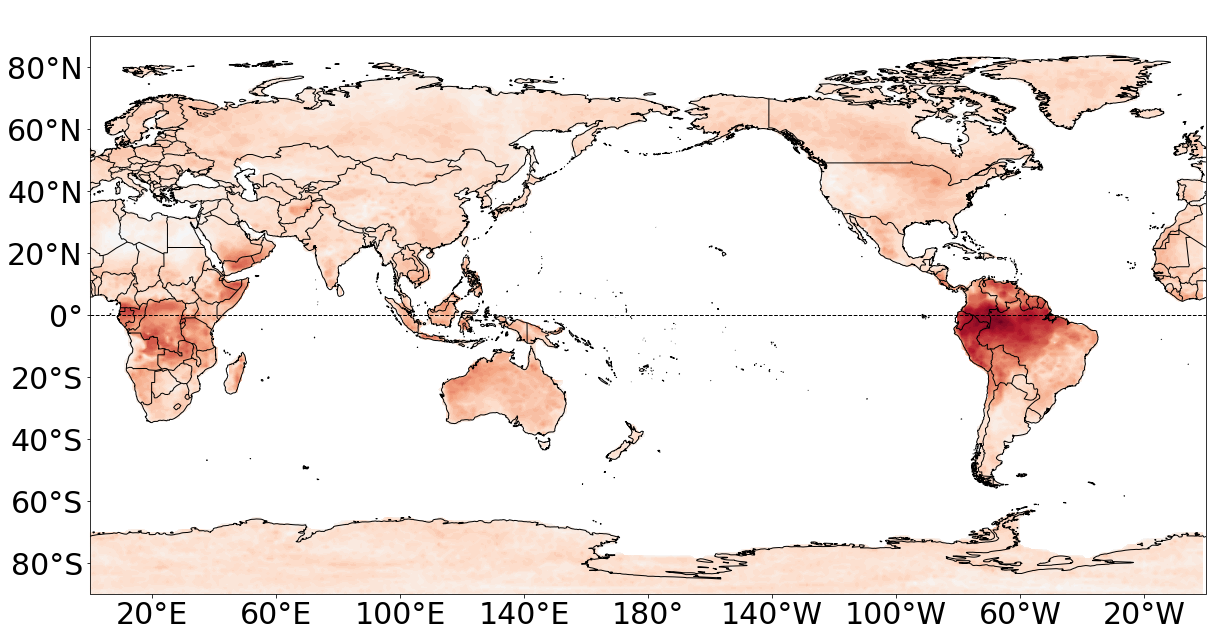

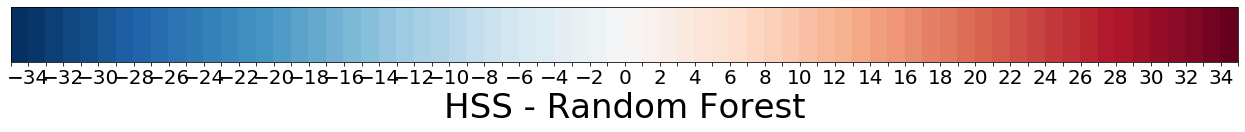

In [26]:
plot_field= HSS_map.squeeze()*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-35,36,1) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([-180,180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-80,100,20), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
# ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('HSS - Random Forest',fontsize=34) 
plt.show()



In [31]:
#Save that time series... 
fn = '/glade/work/wchapman/ASP_summerschool/Generated_Data/HSS_RandomForest_Rolling_Global_3week.npz'
np.savez_compressed(fn,HSS_map=HSS_map,lat=lat,lon=lon)

In [32]:
#load DJF
fn = '/glade/work/wchapman/ASP_summerschool/Generated_Data/HSS_Johnson_Rolling_Global.npz'
bb=np.load(fn)
HSS_map_Johnson = bb['HSS_map']

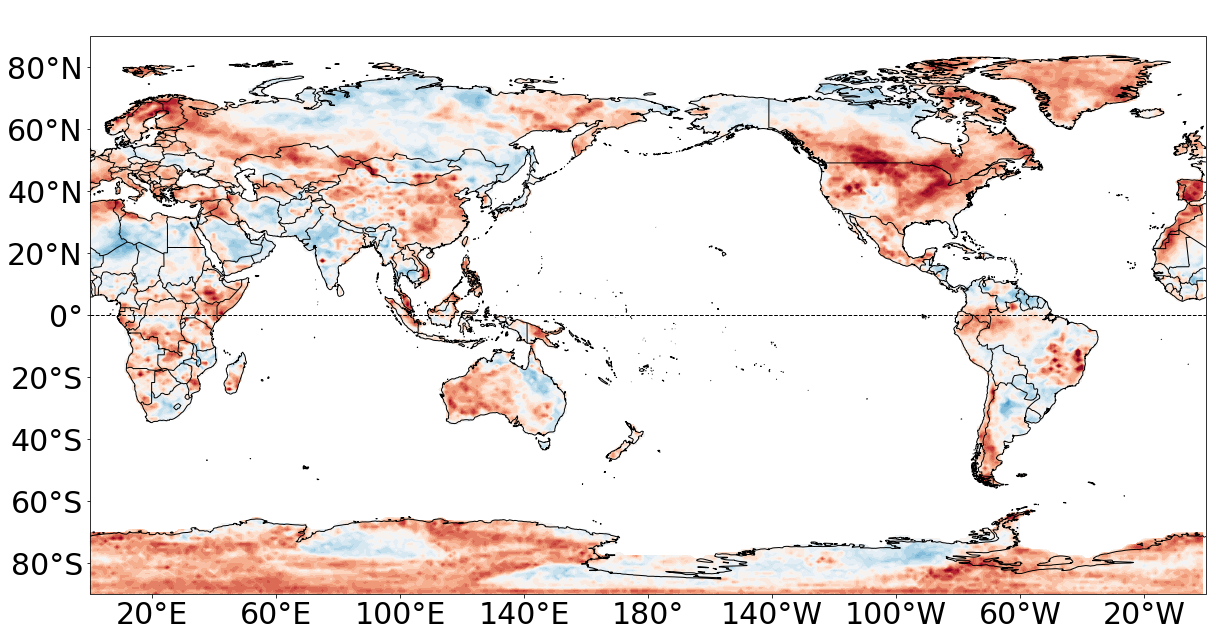

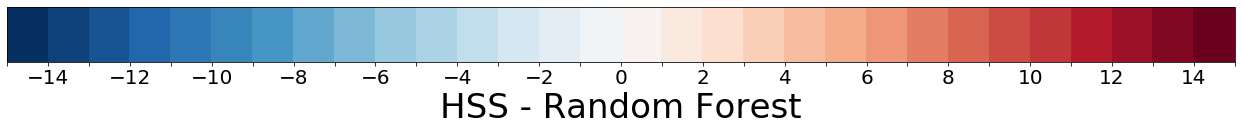

In [34]:
plot_field= (HSS_map.squeeze()*LM)-(HSS_map_Johnson.squeeze()*LM)

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-15,16,1) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([-180,180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-80,100,20), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
# ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('HSS - Random Forest',fontsize=34) 
plt.show()



Low: 0.3333 Mid: 0.3333 High: 0.3333 --- Training
Low: 0.3702 Mid: 0.2596 High: 0.3702 --- Conditional


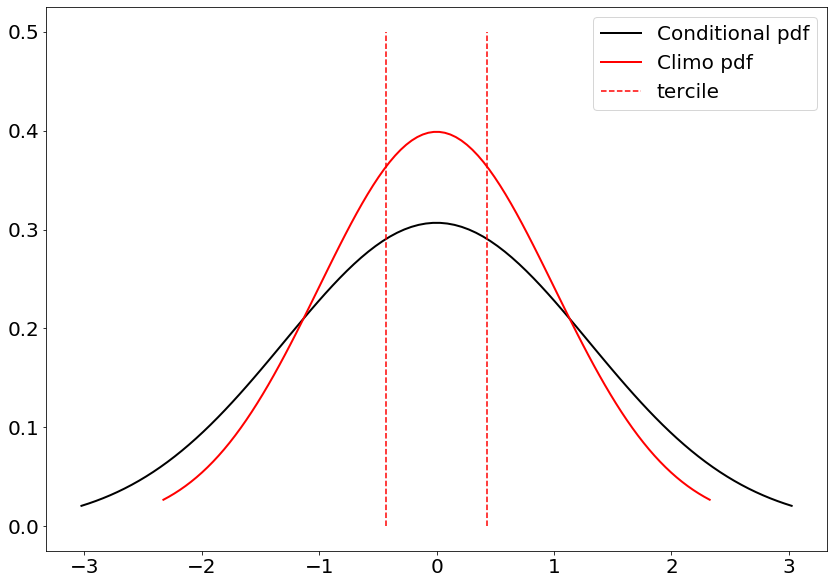

In [32]:
Training_mean=0
Training_std=1

test_mean= 0
test_std= 1.3

threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean, scale=Training_std)
sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean, scale=Training_std)

x = np.linspace(scipy.stats.norm(test_mean, test_std).ppf(0.01),
                scipy.stats.norm(test_mean, test_std).ppf(0.99), 100)
rv = scipy.stats.norm(test_mean, test_std) 
plt.figure(figsize=(14,10))
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='Conditional pdf')


x = np.linspace(scipy.stats.norm(Training_mean,Training_std).ppf(0.01),
                scipy.stats.norm(Training_mean,Training_std).ppf(0.99), 100)
rv = scipy.stats.norm(Training_mean,Training_std)
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='Climo pdf')
plt.plot([sixsix,sixsix],[0,0.5],color='r',linestyle='--',label='tercile')
plt.plot([threethree,threethree],[0,0.5],color='r',linestyle='--')
plt.legend(fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


######################################
percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)
percLow = (1-scipy.stats.norm(test_mean, test_std).sf(threethree))
percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)

######################################

percHigh_TR = scipy.stats.norm(Training_mean, Training_std).sf(sixsix)
percLow_TR = (1-scipy.stats.norm(Training_mean, Training_std).sf(threethree))
percNeut_TR = 1 - (1-scipy.stats.norm(Training_mean, Training_std).sf(threethree)) - scipy.stats.norm(Training_mean, Training_std).sf(sixsix)

######################################

print('Low:',np.round(percLow_TR,4),'Mid:',np.round(percNeut_TR,4),'High:',np.round(percHigh_TR,4), '--- Training')
print('Low:',np.round(percLow,4),'Mid:',np.round(percNeut,4),'High:',np.round(percHigh,4), '--- Conditional')


In [ ]:
1

In [31]:
np.sqrt(0.4**2 + 0.87**2)

0.9575489543621256

In [179]:
hits =0
for bb in range(Verif.shape[0]):
    hits+=np.sum(Verif[bb] == Forecast[bb])
    
HSS = (hits-(int(len(Verif)*0.3333)))/(len(Verif)-(int(len(Verif)*0.3333)))*100
HSS

6.160579027099815

In [ ]:
%%time
T2m_Mean_mjo = np.zeros([2,lat.shape[0],lon.shape[0]])

Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']>1].index)
Ninaind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']<-1].index)
Neutind = np.array(DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-1) & (DFforecast_DJFM['ENSO']<1)].index)

MJOthresh = 5
ENSOthresh = 1

# T2m_Mean_mjo = np.mean()

Forecast = np.zeros([DFforecast_DJFM.shape[0],lat.shape[0],lon.shape[0]])
Verif = np.zeros([DFforecast_DJFM.shape[0],lat.shape[0],lon.shape[0]])
count = 0
for ii,yrs in enumerate(np.unique(DFforecast_DJFM['Year'])[::2]):
    print('year:',yrs)
    
    
    Training_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)].index)
    Test_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs)|(DFforecast_DJFM['Year']==yrs+1)].index)
    
    Training_mean = np.mean(TS[Training_inds,:,:],axis=0)
    Training_std = np.std(TS[Training_inds,:,:],axis=0)
    
    Ninoind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Ninaind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']<-ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Neutind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-ENSOthresh) & (DFforecast_DJFM['ENSO']<ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    MJO_0 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==0)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_1 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==1)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_2 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==2)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_3 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==3)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_4 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==4)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_5 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==5)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_6 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==6)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_7 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==7)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_8 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==8)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    
    DF_year = DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs) | (DFforecast_DJFM['Year']==yrs+1) ]
    

    full_mean=np.mean(TS[Training_inds,:,:],axis=0)
    full_std=np.std(TS[Training_inds,:,:],axis=0)
    
#     print('full M/S',full_mean,full_std)
    Nina_mean = np.mean(TS[Ninaind,:,:],axis=0)
    Nino_mean = np.mean(TS[Ninoind,:,:],axis=0)
    Neut_mean = np.mean(TS[Neutind,:,:],axis=0)
    Nina_std = np.std(TS[Ninaind,:,:],axis=0)
    Nino_std = np.std(TS[Ninoind,:,:],axis=0)
    Neut_std = np.std(TS[Neutind,:,:],axis=0)
    
    
    MJO_0_mean = np.mean(TS[MJO_0,:,:],axis=0)
    MJO_1_mean = np.mean(TS[MJO_1,:,:],axis=0)
    MJO_2_mean = np.mean(TS[MJO_2,:,:],axis=0)
    MJO_3_mean = np.mean(TS[MJO_3,:,:],axis=0)
    MJO_4_mean = np.mean(TS[MJO_4,:,:],axis=0)
    MJO_5_mean = np.mean(TS[MJO_5,:,:],axis=0)
    MJO_6_mean = np.mean(TS[MJO_6,:,:],axis=0)
    MJO_7_mean = np.mean(TS[MJO_7,:,:],axis=0)
    MJO_8_mean = np.mean(TS[MJO_8,:,:],axis=0)
    
    MJO_0_std = np.std(TS[MJO_0,:,:],axis=0)
    MJO_1_std = np.std(TS[MJO_1,:,:],axis=0)
    MJO_2_std = np.std(TS[MJO_2,:,:],axis=0)
    MJO_3_std = np.std(TS[MJO_3,:,:],axis=0)
    MJO_4_std = np.std(TS[MJO_4,:,:],axis=0)
    MJO_5_std = np.std(TS[MJO_5,:,:],axis=0)
    MJO_6_std = np.std(TS[MJO_6,:,:],axis=0)
    MJO_7_std = np.std(TS[MJO_7,:,:],axis=0)
    MJO_8_std = np.std(TS[MJO_8,:,:],axis=0)
    
    threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean, scale=Training_std)
    sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean, scale=Training_std)
    
    for yes in range(len(DF_year)): 
        test_MJO = DF_year.iloc[yes]['MJO_Phase']
        test_ENSO = DF_year.iloc[yes]['ENSO']
        index_verif = int(DF_year.iloc[yes]['Ind_3lead'])
        
#         print(test_MJO,test_ENSO)
    
         #MJO test:
        if test_MJO == 0:
#             print('High MJO')
            MJO_test_mean = MJO_0_mean 
            MJO_test_std = MJO_0_std
        elif test_MJO==1:
            MJO_test_mean = MJO_1_mean 
            MJO_test_std = MJO_1_std
        elif test_MJO==2:
            MJO_test_mean = MJO_2_mean 
            MJO_test_std = MJO_2_std
        elif test_MJO==3:
            MJO_test_mean = MJO_3_mean 
            MJO_test_std = MJO_3_std
        elif test_MJO==4:
            MJO_test_mean = MJO_4_mean 
            MJO_test_std = MJO_4_std
        elif test_MJO==5:
            MJO_test_mean = MJO_5_mean 
            MJO_test_std = MJO_5_std
        elif test_MJO==6:
            MJO_test_mean = MJO_6_mean 
            MJO_test_std = MJO_6_std
        elif test_MJO==7:
            MJO_test_mean = MJO_7_mean 
            MJO_test_std = MJO_7_std
        elif test_MJO==8:
            MJO_test_mean = MJO_8_mean 
            MJO_test_std = MJO_8_std
        else:
            print('..Broken MJO..')
            break
        
        if test_ENSO > ENSOthresh:
#             print('High ENSO')
            ENSO_test_mean = Nino_mean
            ENSO_test_std = Nino_std
        elif test_ENSO < -ENSOthresh:
#             print('LOW ENSO')
            ENSO_test_mean = Nina_mean
            ENSO_test_std = Nina_std
        else: 
#             print('Neut ENSO')
            ENSO_test_mean = Neut_mean
            ENSO_test_std = Neut_std
    
        test_mean = ENSO_test_mean + MJO_test_mean
        test_std = np.sqrt(ENSO_test_std**2+MJO_test_std**2)
        
        
        
#         print('full M/S',full_mean,full_std)
#         print('test M/S:',test_mean,test_std)
#         print('33rd, 66th',threethree,sixsix)
        
        percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)

        percLow=(1-scipy.stats.norm(test_mean, test_std).sf(threethree))
        
        percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)
        
        Forecast[count,:,:] = np.argmax(np.concatenate([percLow[None,...],percNeut[None,...],percHigh[None,...]]),axis=0)
        
        verif_val = TS_ver[index_verif,:,:]   
        
        
        Verif[count,:,:]= verif_val.squeeze()
        count+=1


year: 600
year: 602
year: 604
year: 606
year: 608
year: 610
year: 612
year: 614
year: 616
year: 618
year: 620
year: 622
year: 624
year: 626
year: 628
year: 630
year: 632


## Heidiki Skill Score

In [ ]:
%%time
HSS_map = np.zeros([lat.shape[0],lon.shape[0]])
lenVerif = Verif.shape[0]
hits =0
for lai in range(lat.shape[0]):
    if lai % 10 ==0:
        print('doing latitude:',lat[lai],'working towards latitude:',lat[-1])
    for loi in range(lon.shape[0]):
        hits=sum(Verif[:,lai,loi].squeeze() == Forecast[:,lai,loi].squeeze())
    
        HSS = (hits-(int(lenVerif*0.3333)))/(lenVerif-(int(lenVerif*0.3333)))*100
        HSS_map[lai,loi]=HSS


In [ ]:
plot_field= HSS_map.squeeze()*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-30,31,1) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([-180,180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-80,100,20), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
# ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()


Low: 0.3988346272555827 Mid: 0.35945334898860526 High: 0.24171202375581202


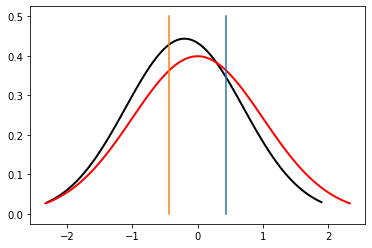

In [223]:

Training_mean=0
Training_std=1

test_mean=-.20
test_std=0.9

threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean, scale=Training_std)
sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean, scale=Training_std)

x = np.linspace(scipy.stats.norm(test_mean, test_std).ppf(0.01),
                scipy.stats.norm(test_mean, test_std).ppf(0.99), 100)
rv = scipy.stats.norm(test_mean, test_std)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


x = np.linspace(scipy.stats.norm(Training_mean,Training_std).ppf(0.01),
                scipy.stats.norm(Training_mean,Training_std).ppf(0.99), 100)
rv = scipy.stats.norm(Training_mean,Training_std)
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='frozen pdf')
plt.plot([sixsix,sixsix],[0,0.5])
plt.plot([threethree,threethree],[0,0.5])


percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)

percLow = (1-scipy.stats.norm(test_mean, test_std).sf(threethree))
        
percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)

print('Low:',percLow,'Mid:',percNeut,'High:',percHigh)


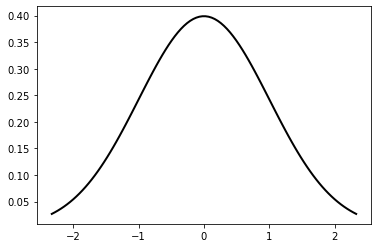

In [396]:
x = np.linspace(norm(0,1).ppf(0.01),
                norm(0,1).ppf(0.99), 100)
rv = norm(0,1)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [321]:
for yes in range(len(DF_year)): 
    test_MJO = DF_year.iloc[yes]['MJO_INDEX']
    test_ENSO = DF_year.iloc[yes]['ENSO']
    
    if test_MJO > MJOthresh:
        MJO_test_mean = MJO_strong_mean 
    else:
        MJO_test_mean = MJO_weak_mean 
        
    if test_ENSO > ENSOthresh:
        ENSO_test_mean = Nino_mean
        ENSO_test_std = Nino_std
    elif test_ENSO < -ENSOthresh:
        ENSO_test_mean = Nina_mean
        ENSO_test_std = Nina_std
    else: 
        ENSO_test_mean = Neut_mean
        ENSO_test_std = Neut_std

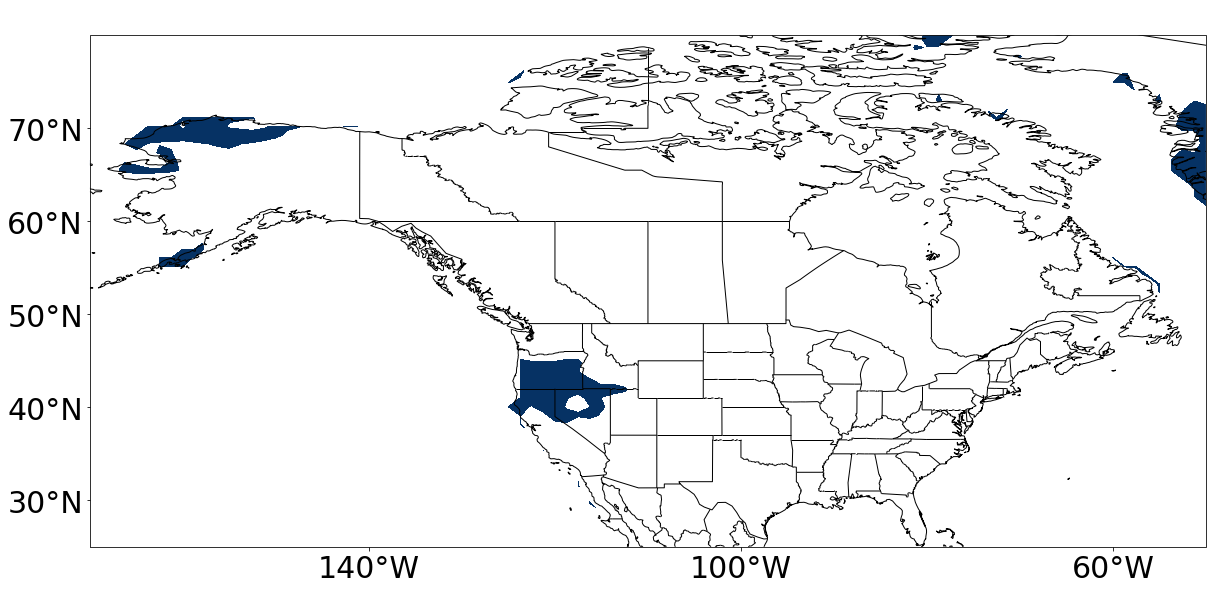

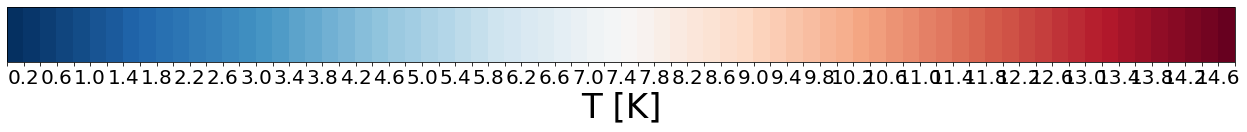

In [274]:
plot_field= Training_mean*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(0,15,0.2) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()
